<a href="https://colab.research.google.com/github/rajy4683/MonoMaskDepth/blob/master/DataSetMeanStd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import sys

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
sys.path.append('/content/drive/My Drive/EVA4/RekogNizer')
sys.path.append('/content/drive/My Drive/EVA4')
sys.path.append('/content/drive/My Drive/EVA4/DenseDepth')

In [0]:
!cd /content/drive/My\ Drive/EVA4

In [0]:
!git clone https://github.com/nianticlabs/monodepth2.git

Cloning into 'monodepth2'...
remote: Enumerating objects: 138, done.
remote: Total 138 (delta 0), reused 0 (delta 0), pack-reused 138
Receiving objects: 100% (138/138), 10.25 MiB | 5.70 MiB/s, done.
Resolving deltas: 100% (65/65), done.


In [0]:
!folder_list=("classroom" "college_outdoors" "corridors" "dining_room" "malls" "lobby" "meeting_rooms" "people_cropresize"); for folder_name in ${folder_list[@]}; do mkdir -p /content/S15EVA4/$folder_name /content/S15EVA4/$folder_name/aug_images; cp -Rf /content/drive/My\ Drive/EVA4/tsai/S15EVA4/$folder_name/*png /content/S15EVA4/$folder_name; done

### Dependencies


In [0]:
!pip install -r /content/drive/My\ Drive/EVA4/RekogNizer/requirements.txt

In [0]:
!pip install -U git+https://github.com/albu/albumentations

In [0]:
import os

import numpy as np
import cv2
from matplotlib import pyplot as plt
from skimage.color import label2rgb

import albumentations as A
import random
from google.colab.patches import cv2_imshow
from PIL import Image
import glob
import pandas as pd

import torch
from zipfile import ZipFile
import re

In [0]:
df_data_list = pd.read_csv('/content/drive/My Drive/EVA4/tsai/S15EVA4/DepthMapDataSet.csv')
df_train = pd.read_csv('/content/drive/My Drive/EVA4/tsai/S15EVA4/DepthMapDataSetTrain.csv')
df_test = pd.read_csv('/content/drive/My Drive/EVA4/tsai/S15EVA4/DepthMapDataSetTest.csv')

In [0]:
df_sample_train = pd.read_csv('/content/drive/My Drive/EVA4/tsai/S15EVA4/DepthMapDataSetSample.csv')


In [0]:
import torch
import torchvision
import torchvision.transforms as transforms
from RekogNizer import hyperparams

from albumentations import Compose, RandomCrop, Normalize, HorizontalFlip, Resize, Cutout, MotionBlur
from albumentations import (
    HorizontalFlip, Compose, RandomCrop, Cutout,Normalize, HorizontalFlip, RandomBrightnessContrast,
    Resize,RandomSizedCrop, MotionBlur,MultiplicativeNoise,InvertImg, IAAFliplr,
	IAAPerspective,
)
from albumentations.pytorch import ToTensor
import random

from torchvision.datasets.vision import VisionDataset
from torchvision.datasets.utils import check_integrity, download_and_extract_archive
import os
import sys
import numpy as np
from torchvision import datasets
#from RekogNizer import imgnetloader
from torch.utils.data import Dataset
import shutil 

In [0]:
random.seed(42)

#cv2.imread('images/parrot.jpg')

flip = A.Compose([
    A.IAAFliplr(p=1,always_apply=True),
    # A.RandomBrightnessContrast(p=1),    
    # A.RandomGamma(p=1),    
    # A.CLAHE(p=1),    
], p=1)

resize_bg = A.Compose([
    A.Resize(250,250,always_apply=True,p=1),
    #A.CLAHE(p=1),
    #A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=50, val_shift_limit=50, p=1),
], p=1)


strong = A.Compose([
    A.ChannelShuffle(p=1),
], p=1)

base_tensor = A.Compose([
    A.pytorch.ToTensor(),
], p=1)

In [0]:
from io import BytesIO
class DepthMaskDataSet(Dataset):
    """Depth and Mask prediction Dataset.
    """


    def __init__(self, csv_file, root_dir, transform=None, target_transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with depth_images, base_images, mask_images and respective zip files.
            root_dir (string): Base dir containing main zip files for depth and image/mask zip files.
            transform (tuple of callable, optional): Optional transform to be applied on depth and mask.
        """
        self.depthmask_csv = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform_base = transform
        self.transform_target = target_transform
        self.image_file_zip_dict = {val:ZipFile(os.path.join(self.root_dir,val)) 
                                    for val in self.depthmask_csv['BaseImageFName'].unique()}
        self.depth_zip_dict = {val:ZipFile(os.path.join(self.root_dir,val)) 
                                    for val in self.depthmask_csv['DepthImageFName'].unique()}
        
        self.bg_image_zip_dict = ZipFile("/content/drive/My Drive/EVA4/tsai/S15EVA4/bg_images.zip")
        # if transform:
        #     self.transform_base = transform
        #     #self.transform_mask = transform[1]
        # if target_transform
        #     self.transform_base = None
        #     #self.transform_mask = None

    def __len__(self):
        return len(self.depthmask_csv)
    """
        Returns {
            inputs:[overlayed_image, background_image], 
            targets:[gt_depth_map, gt_mask]
            }
        Index(['ImageName', 'MaskName', 'Depthname', 'BGImageName', 'BaseImageFName',
       'DepthImageFName', 'BGType']
    """
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        base_img_name = self.depthmask_csv.iloc[idx, 0]
        mask_img_name = self.depthmask_csv.iloc[idx, 1]
        depth_img_name = self.depthmask_csv.iloc[idx, 2]
        bg_image_name = self.depthmask_csv.iloc[idx, 3]
        base_img_zip = self.image_file_zip_dict[self.depthmask_csv.iloc[idx, 4]]
        #ZipFile(os.path.join(self.root_dir,
        #                        self.depthmask_csv.iloc[idx, 4]))
        depth_img_zip = self.depth_zip_dict[self.depthmask_csv.iloc[idx, 5]]
        # ZipFile(os.path.join(self.root_dir,
        #                         self.depthmask_csv.iloc[idx, 5]))
        #print(base_img_name,mask_img_name,depth_img_name,bg_image_name )
        #print(base_img_zip,depth_img_zip)
        ### GT original inputs
        try:
            base_img = np.array(Image.open(BytesIO((base_img_zip.read(base_img_name)))))
            bg_img = np.array(Image.open(BytesIO(self.bg_image_zip_dict.read(bg_image_name))))
            
            ### GT labels 
            mask_img = np.array(Image.open(BytesIO((base_img_zip.read(mask_img_name)))))
            depth_img = np.array(Image.open(BytesIO((depth_img_zip.read(depth_img_name)))))
            
            #return sample
        except KeyError as key_err:
            print(key_err)
            return None

        if self.transform_base:
           base_img = self.transform_base(image=base_img)['image']
           bg_img = self.transform_base(image=bg_img)['image']
        if self.transform_target:
           mask_img = self.transform_target(image=mask_img)['image']
           depth_img = self.transform_base(image=depth_img)['image']

           #mask_img =  self.transform_mask(mask_img)
        #if self.transform_mask:
        #   


        sample = {'input':list([base_img, bg_img]), 'output':list([mask_img, depth_img]) }
        return sample

In [0]:
#csv_file = '/content/drive/My Drive/EVA4/tsai/S15EVA4/DepthMapDataSetSample.csv'
csv_file ='/content/drive/My Drive/EVA4/tsai/S15EVA4/DepthMapDataSet.csv'
root_dir = '/content/drive/My Drive/EVA4/tsai/S15EVA4'

depth_dataset = DepthMaskDataSet(csv_file, root_dir, transform=None,target_transform=None)

In [0]:
from torch.utils.data import DataLoader
kwargs= { 'num_workers':1,'pin_memory': True}
myloader = DataLoader(depth_dataset, batch_size=512, shuffle=False, **kwargs)

In [0]:
### Knuth/Welford algorithm to generate mean by addition of new samples to existing mean

def update_mean_variance(existingAggregate, newValue):
    (count, mean, M2) = existingAggregate
    count += 1
    delta = newValue - mean
    mean += delta / count
    delta2 = newValue - mean
    M2 += delta * delta2

    return (count, mean, M2)

# Retrieve the mean, variance and sample variance from an aggregate
def finalize_mean_variance(existingAggregate):
    (count, mean, M2) = existingAggregate
    if count < 2:
        return float('nan')
    else:
       (mean, variance, sampleVariance) = (mean, M2 / count, M2 / (count - 1))
       return (mean, variance, sampleVariance)

In [0]:
from tqdm import tqdm
 
pbar = tqdm(depth_dataset)

#bg_mean = np.zeros((4,3))
n, mean, M2 = (0.0,0.0,0.0)
for i_batch,img in enumerate(pbar):
    #img = depth_dataset[i_batch]
    #img_mean = np.mean(img, axis=(0,1))
    img_mean = np.array([ np.mean(iter_val/255.0,axis=(0,1)) for left_k,right_v in img.items() for iter_val in right_v ])
    n, mean, M2 = update_mean_variance((n, mean, M2), img_mean)

print(finalize_mean_variance(n, mean, M2))

100%|██████████| 483820/483820 [2:04:16<00:00, 64.88it/s]


TypeError: ignored

In [0]:
calc_mean,variance, _ = finalize_mean_variance((n, mean, M2))
print(calc_mean)
print(np.sqrt(variance))

[[0.56632738 0.51567622 0.45670792]
 [0.57469445 0.52241555 0.45992244]
 [0.05795104 0.05795104 0.05795104]
 [0.61635181 0.21432114 0.50569604]]
[[0.1076622  0.10650349 0.12808967]
 [0.11322354 0.11195428 0.13441683]
 [0.02640032 0.02640032 0.02640032]
 [0.09193359 0.07619106 0.04919082]]


In [0]:
#depth_map = np.hstack([depth_dataset[index_val]['output'][1] for index_val in myrandom_array])
depth_map = [depth_dataset[index_val]['output'][1] for index_val in myrandom_array]
mask_image = [depth_dataset[index_val]['output'][0] for index_val in myrandom_array]
bg_image = [depth_dataset[index_val]['input'][1] for index_val in myrandom_array]
fg_bg_image = [depth_dataset[index_val]['input'][0] for index_val in myrandom_array]
final_list = np.hstack([ mask_image, bg_image, fg_bg_image])

In [0]:
from matplotlib import pyplot as plt

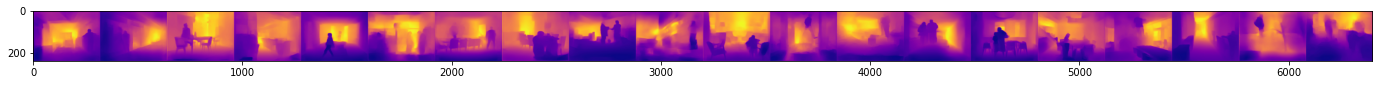

In [0]:
plt.figure(figsize=(24,32))
plt.imshow(depth_map,cmap='gray')

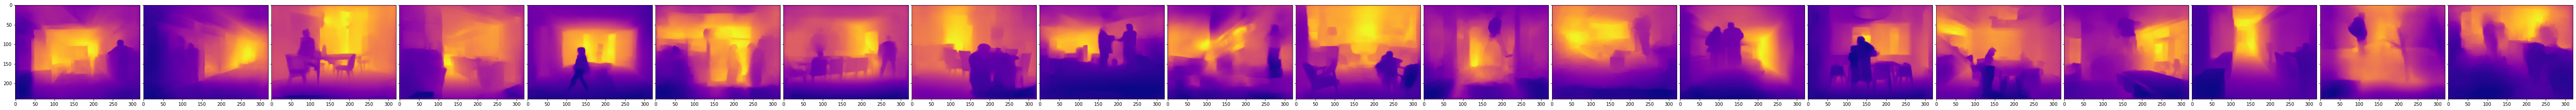

In [0]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np

fig = plt.figure(figsize=(100., 100.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(1, 20),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )
for ax, im in zip(grid, depth_map):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)

plt.show()

In [0]:
plt.savefig('/content/drive/My Drive/EVA4/tsai/S15EVA4/depthmaptile.png')

<Figure size 432x288 with 0 Axes>

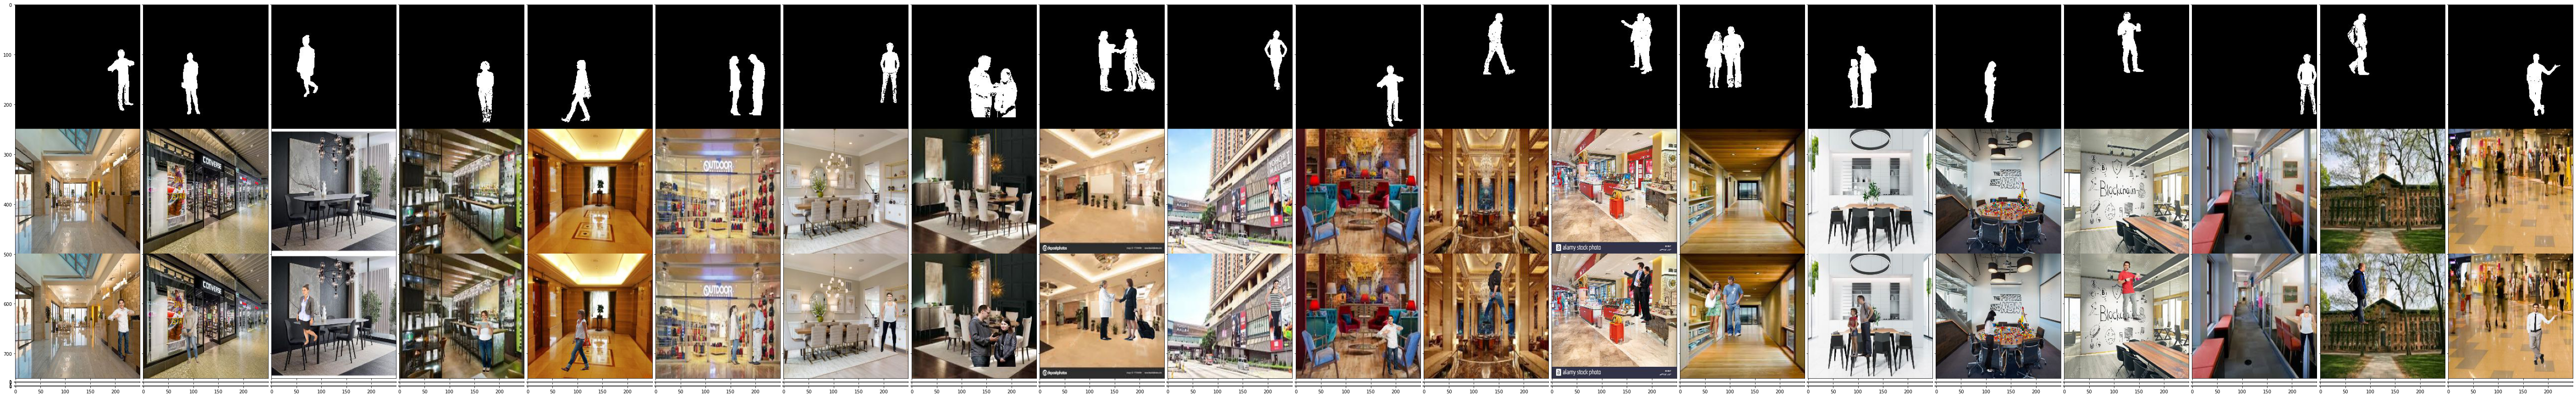

In [0]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np

fig = plt.figure(figsize=(100., 100.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(3, 20),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )
for ax, im in zip(grid, final_list):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)

plt.show()

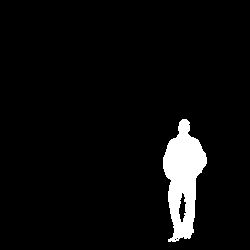

In [0]:
Image.fromarray(depth_dataset[0]['output'][0])

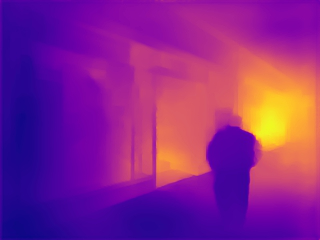

In [0]:
Image.fromarray(depth_dataset[0]['output'][1])